# RefFreeEWAS Example: a Vignette

This notebook demonstrates functionality in the CRAN package [*RefFreeEWAS*](https://cran.r-project.org/web/packages/RefFreeEWAS/index.html), specifically that described in [Houseman, Kile et al. (2016)](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-1140-4), *Reference-free deconvolution of DNA methylation data and mediation by cell composition effects*.  This notebook in particular discusses how to initialize the procedure using SVD, a subject discussed in a recent [data challenge workshop](https://data-institute.univ-grenoble-alpes.fr/research/data-science-for-life-sciences/health-data-challenge-matrix-factorization-and-deconvolution-methods-to-quantify-tumor-heterogeneity-in-cancer-research-756672.htm) and a topic of a forthcoming paper.

<img src='https://media.springernature.com/full/springer-static/image/art%3A10.1186%2Fs12859-016-1140-4/MediaObjects/12859_2016_1140_Fig1_HTML.gif'>

<small>**Figure 1** from [Houseman, Kile et al. (2016)](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-1140-4): Overview of proposed Methods. If associations between DNA methylation data $Y$ and phenotypic metadata $X$ factor through the decomposition $Y = M\Omega^T$ , and the data in $M$ serve to distinguish cell types by their associations with relevant annotation data, then associations between $X$ and $Y$ are explained in whole or in part by differences in the distribution of constituent cell types. Numbers indicate steps in analysis: (1) deconvolution; (2) determining discriminating loci; (3) gene-set analysis; (4) analysis of associations with phenotype.</small>


**Directions**:  Please create a working directory and extract the contents of this [zip file](
https://github.com/eahouseman/RefFreeEWAS/blob/master/GSE20712Data.zip).  The original data was obtained from [Gene Expression Omnibus](ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE20nnn/GSE20712/matrix/).  

The code block below sets the working directory, load libraries and data, and creates some useful global variables.

In [1]:
# Change working directory to an appropriate location
setwd('C:\\Users\\eahou\\Documents\\Vignettes\\RefFreeEWAS')

################ ################ ################
# Load libraries
library(RefFreeEWAS)
library(RColorBrewer)

############### ################
# Load data example
# (GSE20712 from Gene Expression Omnibus)
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE20712
# Data from here: ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE20nnn/GSE20712/matrix/ 
load("GSE20712.RData")

############### ################
# Create some global variables necessary for the analyses

# The microarray data that will be deconvolved:
Y.all = dataGSE.20712$assay 

# Indices of tumor data
tumSelect = which(dataGSE.20712$pheno$Source=="Breast tumor")

# Indices of non-pathologial data
normSelect = which(dataGSE.20712$pheno$Source=="Normal breast tissue")

# IHC class of tumor
tumClass = factor(dataGSE.20712$pheno$subtypeihc[tumSelect])

# Color palette for indicating tumor class in various plots
tumColor = brewer.pal(length(levels(tumClass)),"Set1")

Loading required package: quadprog


It's best to use a subset of the entire microarray, consisting of CpGs that are likely to be informative for distinguishing types.  Note that we don't want to select CpGs based on explicit statistical criteria regarding their ability to differentiate tumor, otherwise subsequent regressiona analyses will be "contaminated" by the initial selection process, leading to biased p-values.  See the literature on [semi-supervised learning](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C48&q=semi-supervised+learning&btnG=) for more details.

Below we demonstrate one possible selection criteria based on PCA (similar to a common approach for selecting informative SNPs in genotype analysis).

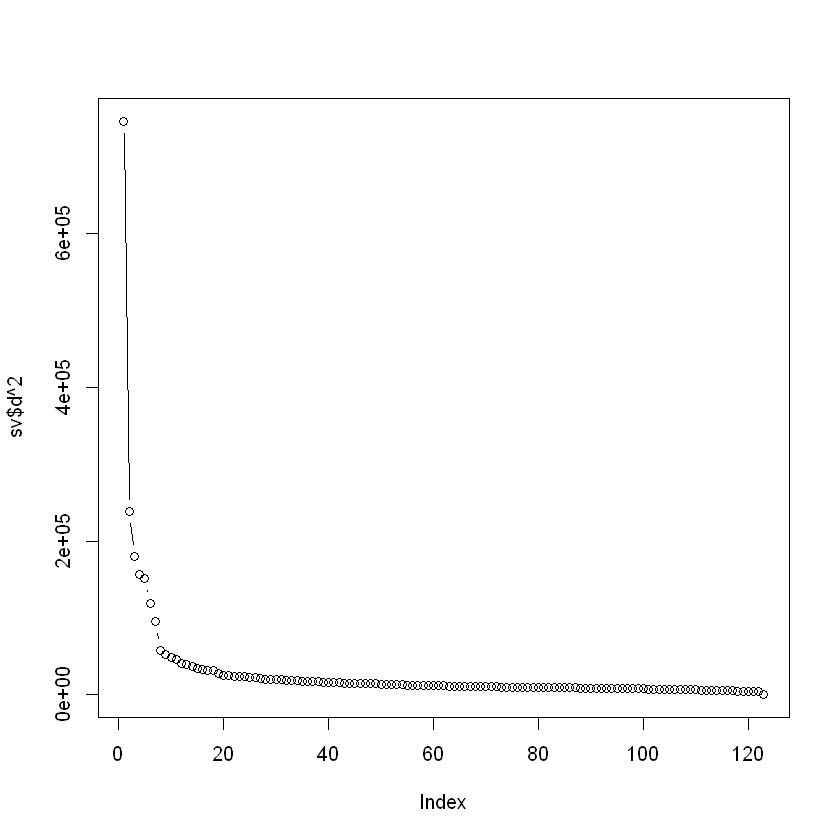

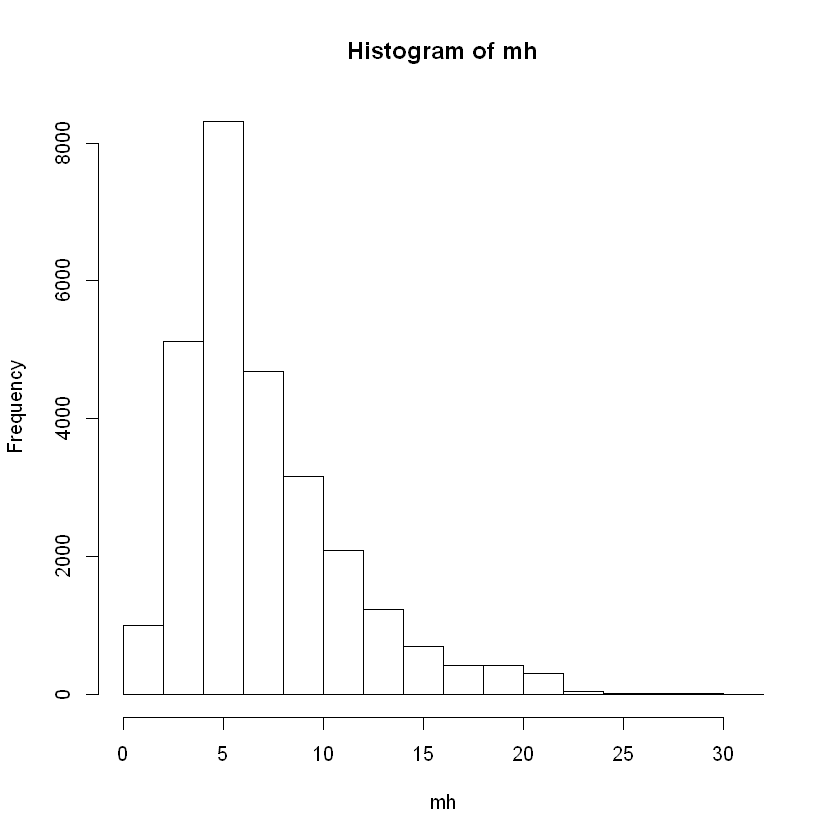

In [2]:
########################
# CpG selection by PCA

sv = svd(scale(t(Y.all)))    # PCA
plot(sv$d^2,type="b")        # Scree plot

# Select first (7?) PCs
pcSelect =  sv$v[,1:7]  

# Mahalanobis distances of selected loadings
mh = mahalanobis(pcSelect, apply(pcSelect,2,mean), cov(pcSelect))
hist(mh)

# CpGs that we will use for deconvolution
cpgSelect = order(mh, decreasing=TRUE)[1:5000]  # Select (5000?) most informative CpGs 

# Microarray subset consisting of selected CpGs only
Ysel = Y.all[cpgSelect,]


Now we attempt to find the best value of $K$, the number of assumed cell types.  First we fit deconvolutions for a range of values of $K$, then we perform a bootstrap procedure to estimate the out-of-box deviance for each value of $K$.

Note that both the deconvolution step and the bootstrap step could take quite a while to run.

In [3]:
########################
# Cell mixture array with custom start (SVD)

# Get PCs (without standardization)
svSel = svd(Ysel)

# Initial deconvolution (note, this could take awhile)
cellmixArray  <- RefFreeCellMixArrayWithCustomStart(Ysel, 
    mu.start = svSel$u,  # Initial methylome matrix 
    Klist=1:12,          # List of K values to try (# constituent cell types)
    iters=25             # Number of iterations per value of K
)

Fitting K = 1 
Fitting K = 2 
Fitting K = 3 
Fitting K = 4 
Fitting K = 5 
Fitting K = 6 
Fitting K = 7 
Fitting K = 8 
Fitting K = 9 
Fitting K = 10 
Fitting K = 11 
Fitting K = 12 


In [4]:
########################
# Bootstrap
# Do the bootstrap for selecting the K parameter (# assumed cell types)
cellmixArrayBoot <- RefFreeCellMixArrayDevianceBoots(
   cellmixArray,            # Array object
   Y=Ysel,                  # Data on which array was based
   R=100,                   # 100 bootstraps for example (should really use 500 or so)
   bootstrapIterations=10)  # Num iterations per bootstrap (can be smaller than above)


Bootstrap 10 
Bootstrap 20 
Bootstrap 30 
Bootstrap 40 
Bootstrap 50 
Bootstrap 60 
Bootstrap 70 
Bootstrap 80 
Bootstrap 90 
Bootstrap 100 


Now visualize the results of the boostrap analysis and select the value of $K$ with the smallest deviance, as measured by trimmed (Winsorized) mean.  

Note that the first element of every element of `cellmixArrayBoot` is the non-bootstrapped deviance, so it needs to be removed from the analyses below. Note also that while the `Omega` element of the `cellmixArray` object represents the cell proportions corresponding to each sample, the `Mu` element respresents the cell-specific methylome over *only* the CpGs used for the deconvolution.  Another step will be needed to compute the cell-specific methylome over *all* CpGs (see below).

1         2         3         4         5         6         7         8 
-5309.786 -6665.512 -6939.240 -7212.629 -7527.931 -6884.021 -6556.346 -6354.159 
        9        10        11        12 
-5588.558 -4989.518 -4665.088 -4212.221

5 
5

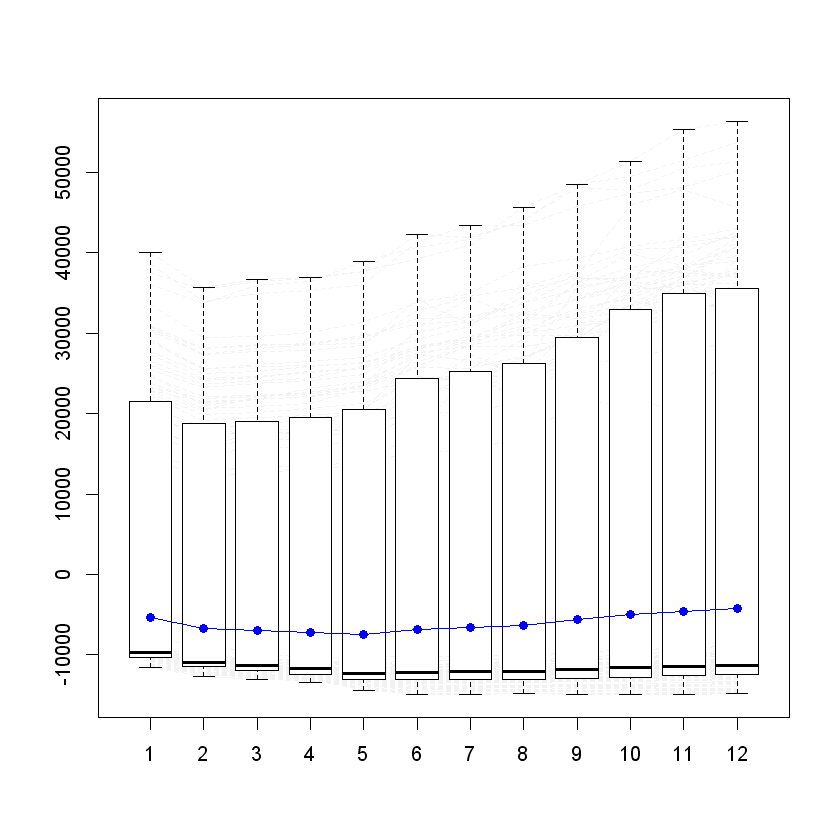

In [5]:
########################
# Selecting K

# Show winsorized mean deviance per K
wnsrMeanDev <-apply(cellmixArrayBoot[-1,], 2, mean, trim=0.25)
wnsrMeanDev

# View bootstraps
boxplot(cellmixArrayBoot[-1,],type="n")
for(i in 1:100) lines(1:12,cellmixArrayBoot[1+i,],col=hsv(0,0,0.95),lty=2)
boxplot(cellmixArrayBoot[-1,],add=TRUE)
points(1:12, wnsrMeanDev, pch=19, col="blue")
lines(1:12, wnsrMeanDev, col="blue")

# Choose K based on minimum deviance
Kchoose <- which.min(wnsrMeanDev)
Kchoose

# Chosen Omega
Omega <- cellmixArray[[ Kchoose ]]$Omega # The cell mixture matrix
MuSmall <- cellmixArray[[ Kchoose ]]$Mu




Next we visualize the cell proportion data for normal and tumor data separately.  Note the uniformity of the normal data relative to the tumor data!

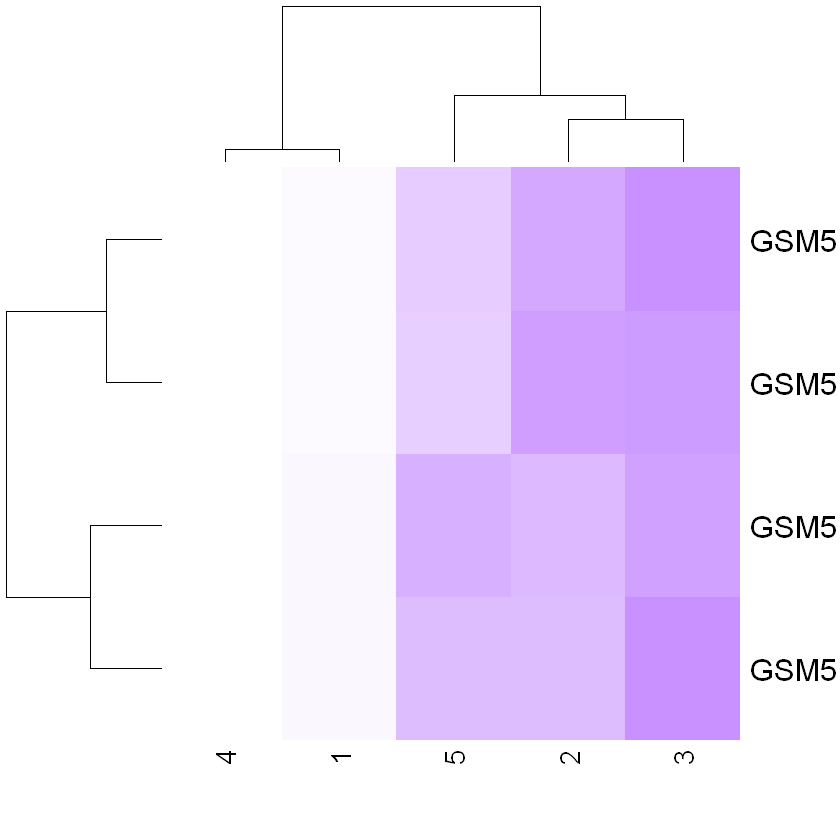

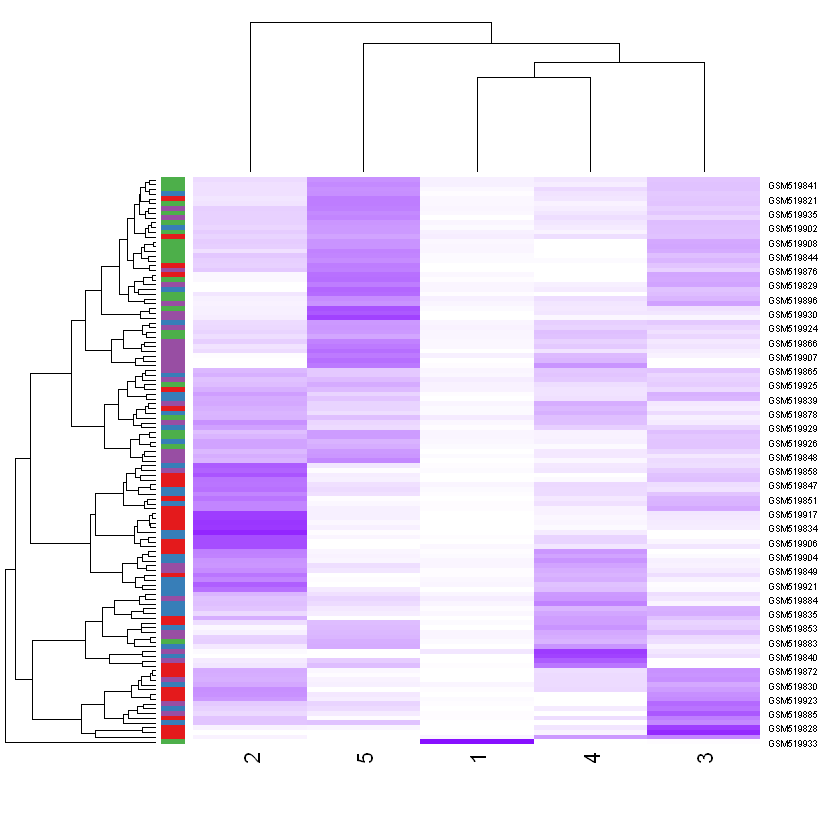

In [6]:
########################
# Visualizing the Omega matrix
heatPalette = hsv(0.75,(0:100)/100,1)  # Heatmap color palette

# Normal
heatmap(Omega[normSelect,],scale="n",zlim=c(0,1),col=heatPalette)

# Tumor
heatmap(Omega[tumSelect,],scale="n",zlim=c(0,1),col=heatPalette,
   RowSideColor=tumColor[as.numeric(tumClass)])

Now we get the methylome matrix for the entire microarray:

In [7]:
########################
# Get Mu for the entire array (not just the CpGs that were selected for deconvolution)
Mu <- projectMix(t(Y.all), Omega)

# Compare
dim(Mu)
dim(MuSmall)

[1] 27578     5

[1] 5000    5

Next we demonstrate how to look for associations between methylomes `Mu` and genomic annotation data.
For this example we will use polycomb target gene (PcG) annotation (as described in the [paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-1140-4)).

In [8]:
################################################
# Analyze associations between Mu and PcG status

PcG = read.delim("PcGTargets27K.txt", head=TRUE, stringsAsFactors=FALSE)

# Read the 27K annotation file
annot = read.table("CpG-annotation-Infinium.txt",
  sep="\t", head=TRUE, stringsAsFactors=FALSE)

# Compute a PcG score (as described in the paper)
PcGScore = apply(as.matrix(PcG[,-(1:2)]), 1, sum)
names(PcGScore) = PcG$EntrezGene.ID

# Construct the PcG annotation vector over all CpGs,
#  merging by Entrez Gene ID.
tmpPcG = rep(0,nrow(annot))
names(tmpPcG) = annot$Entrez
tmpIsect = intersect(names(tmpPcG),names(PcGScore))
tmpPcG[tmpIsect] = PcGScore[tmpIsect]
annot$PcG = tmpPcG


Next, look at the association of row-specific variation and PcG status.  Compare with the results from PCA.  In particular, compare the Kruskal-Wallis p-values and correlations.

In [9]:
# Check to make sure the ordering of the annotation file
#  matches the microarray data
all(rownames(Y.all)==annot$Name)

# For each CpG, compute the methylation variance across cell "types"
v.Mu = apply(Mu,1,var)

# Calculate correlation matrices and compare
cat('Correlation with Cell Proportions:\n')
print(round(cor(Mu,pmin(annot$PcG,3)),3))
cat('\nCorrelation with PC Scores:\n')
print(round(cor(PCs,pmin(annot$PcG,3)),3))

# Test whether there is a difference using the Kruskal-Wallis test
cat('\nCell Proportions:\n')
print(kruskal.test(v.Mu~pmin(annot$PcG,3)))

# Compare with principal components
PCs = sv$v[,1:7]
cat('\nPC Scores:\n')
print(kruskal.test(sv$v[,1]~pmin(annot$PcG,3)))

# Show boxplots
par(mfrow=c(1,2))
boxplot(v.Mu~pmin(annot$PcG,3), xlab='PcG Score', ylab='Variance')
boxplot(sv$v[,1]~pmin(annot$PcG,3), xlab='PC Score', ylab='Variance')
par(mfrow=c(1,1))

[1] TRUE

Correlation with Cell Proportions:
       [,1]
[1,]  0.000
[2,] -0.061
[3,]  0.021
[4,]  0.230
[5,]  0.001

Correlation with PC Scores:


ERROR: Error in is.data.frame(x): object 'PCs' not found


Now we demonstrate how to look for associations between cell proportions and phenotypic metadata.  In this example we will look at the association between cell proportion and tumor type (IHC class) adjusted by age and ER status.

Note that we will use a quasi-binomial generalized linear model (GLM) to account for the approximate Dirichlet distribution followed by the cell proportions.

In [10]:
################################################
# Analyze associations between Omega and Phenotype

#Some values are numerically zero but still have negative sign.
# We need to change the sign so that the GLM does not fail.
range(Omega)
Omega = abs(Omega) 

# Create design matrix
tmpData = dataGSE.20712$pheno[tumSelect,]
tmpData$agebin = as.numeric(tmpData$agebin)
tmpData$er = as.numeric(tmpData$er)
tmpData$er[is.na(tmpData$er)] = 0
#tmpData$her2 = as.numeric(tmpData$her2)

X = model.matrix(~agebin+subtypeihc+er,tmpData)
colnames(X)=gsub("^subtypeihc","",colnames(X))
colnames(X)[colnames(X)=="er"] = "ER"
colnames(X)[colnames(X)=="agebin"] = "older"

# Function for fitting a GLM to all dimensions
GetGLMFits = function(X,Om,family=quasibinomial()){
  #Note: quasibinomial approximates a Dirichlet model
  glmList <- list()
  K = ncol(Om)
  for(j in 1:K){
     om <- Om[,j]
     glmList[[j]] <- glm(om~X-1, family=family)
  }
  glmList
}

glmFitList = GetGLMFits(X,Omega[tumSelect,])
glmFitListPCA = GetGLMFits(X,sv$u[tumSelect,1:7],family=gaussian()) # Compare to PCA

# Regression Coefficients for Age
t(sapply(glmFitList, function(u)summary(u)$coef["Xolder",]))
t(sapply(glmFitListPCA, function(u)summary(u)$coef["Xolder",]))

# Regression Coefficients for Luminal-A
t(sapply(glmFitList, function(u)summary(u)$coef["XLumA",]))
t(sapply(glmFitListPCA, function(u)summary(u)$coef["XLumA",]))


[1] -8.540130e-18  9.405029e-01

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

Estimate,Std. Error,t value,Pr(>|t|)
-0.8581771,0.2828019,-3.0345527,0.002989788
0.2246937,0.1873862,1.1990941,0.232999778
-0.1233869,0.1824051,-0.6764443,0.500140880
0.3986156,0.2148167,1.8556082,0.066115289
-0.2839789,0.1886795,-1.5050857,0.135092172


Estimate,Std. Error,t value,Pr(>|t|)
-0.002494894,0.01800690,-0.1385521,0.89005069
-0.012216085,0.01634848,-0.7472306,0.45647644
-0.005625050,0.01799096,-0.3126599,0.75511536
-0.040305761,0.01742458,-2.3131553,0.02252361
-0.004316511,0.01848441,-0.2335217,0.81577886
-0.025792974,0.01621991,-1.5902048,0.11458257
-0.005259976,0.01745117,-0.3014110,0.76365506


Estimate,Std. Error,t value,Pr(>|t|)
1.6819939,0.7560027,2.2248517,0.0280775106
-1.1708636,0.4107125,-2.8508108,0.0051851196
-0.3526603,0.4144862,-0.8508372,0.3966591581
-0.5211334,0.4711283,-1.1061390,0.2710157237
1.5595327,0.4481803,3.4796995,0.0007141146


Estimate,Std. Error,t value,Pr(>|t|)
0.079071563,0.04010159,1.97178148,0.05107828
0.092090991,0.03640827,2.52939774,0.01280433
-0.039550543,0.04006608,-0.98713274,0.32568654
0.050939285,0.03880476,1.31270727,0.19194145
-0.003278936,0.04116501,-0.07965346,0.93665377
0.061553884,0.03612193,1.70405841,0.09111854
0.091327716,0.03886398,2.34993228,0.02051203


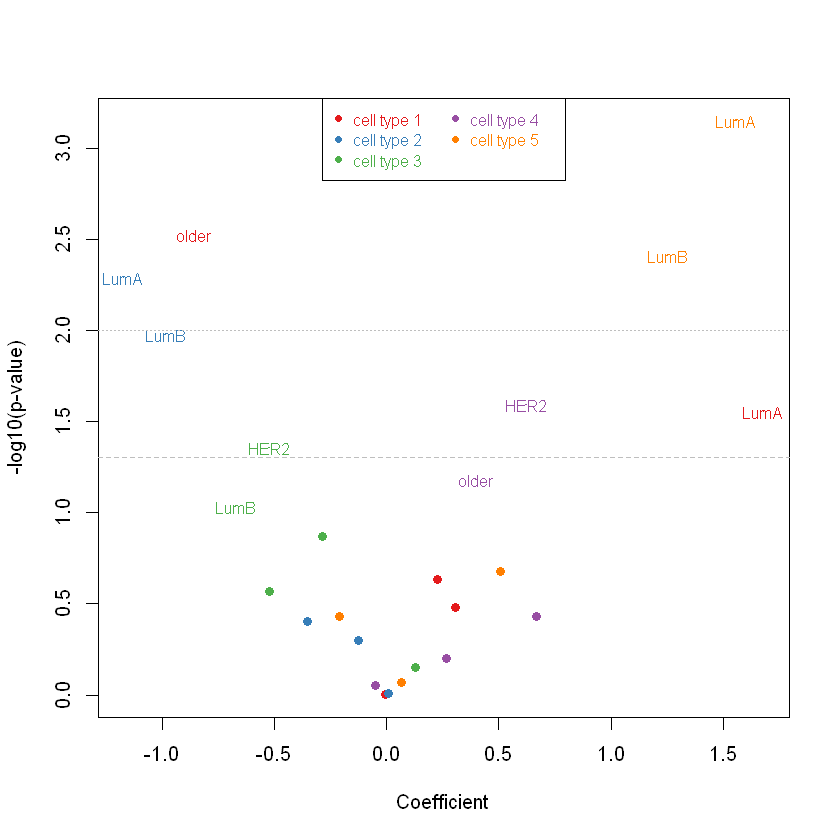

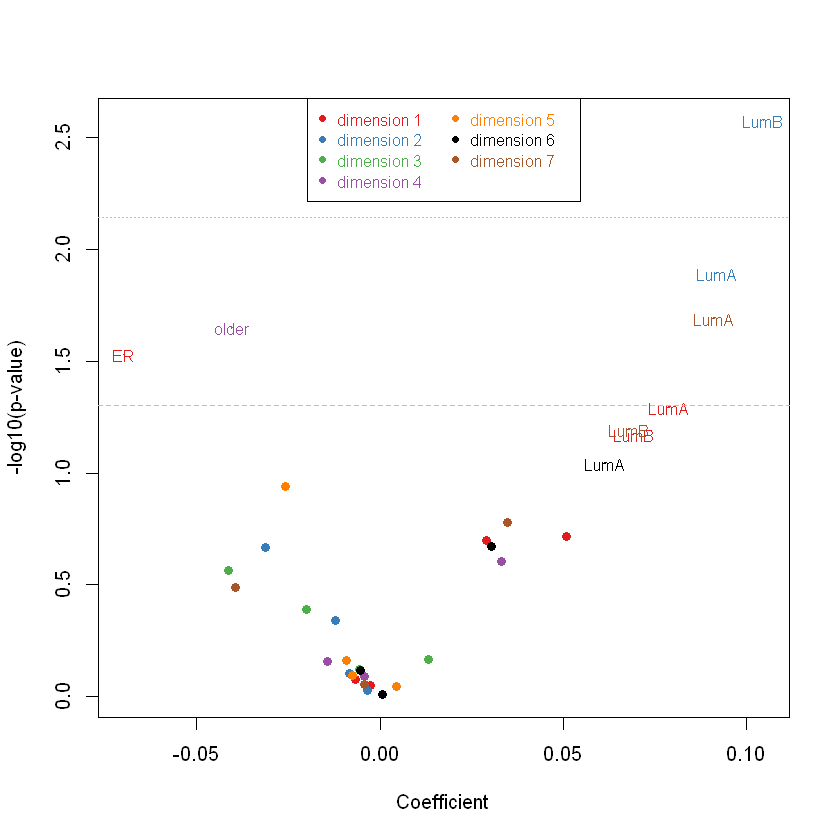

In [11]:
################################################
# Volcano plots

VolcanoByVariable = function(glmList,labelfun=function(x)x,legendpos="topleft",
  labelPrefix="cell type", ncol=1){
  tmp1 = t(sapply(glmList, function(u)summary(u)$coef[,1]))[,-1]
  tmp2 = t(sapply(glmList, function(u)summary(u)$coef[,4]))[,-1]

  xColor = brewer.pal(nrow(tmp1),"Set1")
  xColor[xColor=="#FFFF33"]="black"
  plot(tmp1,-log10(tmp2),col=xColor[row(tmp1)],pch=".",
    xlab="Coefficient", ylab="-log10(p-value)")
  tmp = (tmp2<0.1)
  points(tmp1[!tmp],-log10(tmp2[!tmp]),col=xColor[row(tmp1)], pch=19)

  labels=labelfun(gsub("^X","",colnames(tmp1)))
  text(tmp1[tmp],-log10(tmp2[tmp]), 
    labels[col(tmp1)[tmp]], cex=0.8, col=xColor[row(tmp1)[tmp]])
  abline(h=-log10(0.05),lty=2,col="gray")
  abline(h=-log10(0.05/nrow(tmp1)),lty=3,col="gray")
  legend(legendpos,paste(labelPrefix,1:nrow(tmp1)),
    cex=0.8,col=xColor,pch=19,ncol=ncol,text.col=xColor)
}

# Show volcano plot of Omega by IHC class
VolcanoByVariable(glmFitList,function(x)gsub("^subtypeihc","",x),"top",ncol=2)

# Show volcano plot of PCA by IHC class
VolcanoByVariable(glmFitListPCA,legendpos="top",ncol=2,labelPrefix="dimension")
